In [97]:
import pandas as pd
import folium
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn

In [98]:
def save_map(map_name, filename):
    map_filename = "maps/"+filename+".html"
    map_name.save(map_filename)


In [99]:
#load the dataset of unemployment rate
unemployment_data = pd.read_excel('data/lfsq_urgan.xls')
unemployment_data.columns = np.append("Unemployment rates by citizenship (%)",unemployment_data.iloc[10][1:])

#We drop useless rows and match country names to the ones in the topojson file
unemployment_data = unemployment_data.drop(np.append(range(0,17),range(50,151)))
unemployment_data = unemployment_data.reset_index(drop=True)
unemployment_data['Unemployment rates by citizenship (%)'][4] = 'Germany'
unemployment_data['Unemployment rates by citizenship (%)'][31] = 'The former Yugoslav Republic of Macedonia'
unemployment_data.head()

,Unemployment rates by citizenship (%),2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2
0,Belgium,8.8,8.4,8.2,8.7,8.3,7.9,7.9,7.2,7.7,7
1,Bulgaria,10.6,9.9,8.3,7.9,8.6,8.1,7,6.7,6.9,6.3
2,Czech Republic,6,4.9,4.8,4.5,4.4,3.9,4,3.6,3.5,3
3,Denmark,6.6,6,6.2,5.8,6.3,6,6.3,6.1,6.5,5.5
4,Germany,5,4.7,4.4,4.5,4.5,4.2,4,3.8,4.1,3.8


The most recent complete data we could get is for the second quarter of 2017. There was some more recent data yet there were some missing values for certain countries as Switzerland. We can see that we don't have the data for countries outside of the European Union, we will then need to ignore them in the topojson file when creating our map.

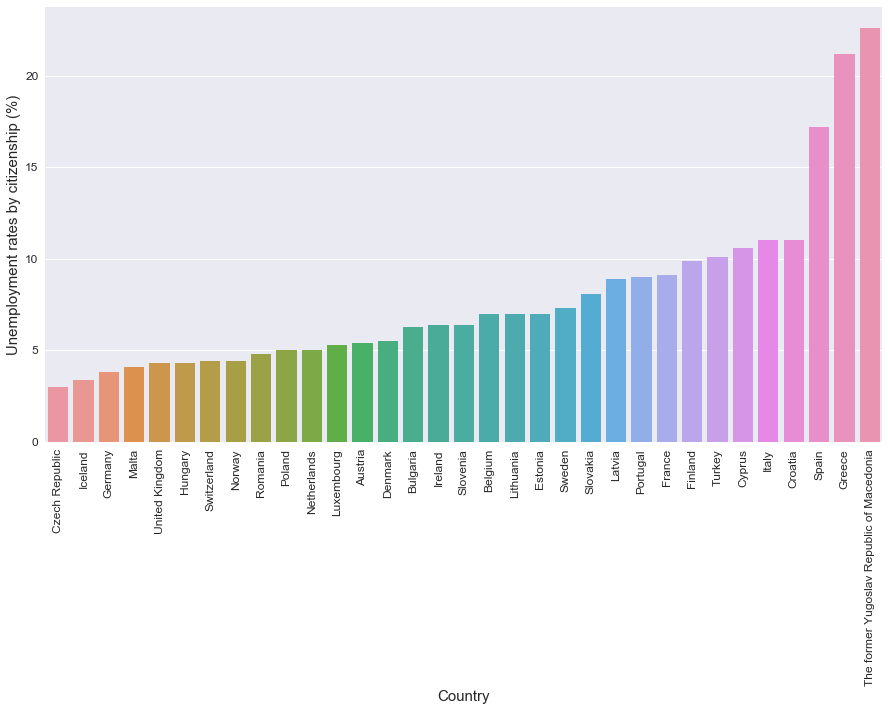

In [100]:
#We can change the period and choose one between the first quarter of 2015 to the second of 2017 here 
#using column names
period = '2017Q2'

#We sort by employement rate for the second quarter of 2017 as it is the most recent data we have 
#for all EU countries and plot it.
unemployment_data = unemployment_data.sort_values(period)
plt.rcParams['figure.figsize']=(15,8)
plt.rcParams["axes.labelsize"] = 15
plot = seaborn.barplot(y=unemployment_data[period], x=unemployment_data['Unemployment rates by citizenship (%)'])
plot.set_xticklabels(labels =unemployment_data['Unemployment rates by citizenship (%)'] ,rotation=90,  fontsize=12)
plot.set_yticklabels(labels =[0,5,10,15,20] ,fontsize=12)
plot.set_ylabel(ylabel='Unemployment rates by citizenship (%)')
plot.set_xlabel(xlabel='Country')
plt.show()


We can see that most values lie between 3% and 12% so we will create our scale so it is more precise (i. e. more interval classes) for these values.

In [101]:
from branca.colormap import linear

#Create colormap
colormap = linear.GnBu.scale(
    unemployment_data[period].min(),
    unemployment_data[period].max())

#creation of interval classes
threshold_scale=[3, 6, 10, 12, 23]

colormap

We choose the linear scale 'GnBu' which is a scale used to represent divergent data using light green colors for weak unemployement rate and dark blue colors for high ones. It also uses colors that can be distinguished by most colorblind people.

In [102]:
#loading topojson data and getting the array of all arcs in the json.
topo_json_data = json.load(open(r'topojson/europe.topojson.json'))
arcIndices = topo_json_data['arcs']

#Function used to map an array of arcs coordinates to an array of longitude and latitude coordinates
def decodeArc(arcs) :
    x=0;y=0
    conversion = []
    for arc in arcs:
        arc1 = (x + arc[0])*topo_json_data['transform']['scale'][0]+topo_json_data['transform']['translate'][0]
        arc2 = (y + arc[1])*topo_json_data['transform']['scale'][1]+topo_json_data['transform']['translate'][1]
        conversion.append([arc1,arc2])
        x += arc[0]
        y += arc[1]
    return conversion

In [103]:
#Takes an array of arc indices and returns the corresponding array of arcs in longitude/latitude 
#coordinates depending on the shape 
def reconstruct_shape(arcIdx,shape):
    if(shape == 'MultiPolygon') :
        layer1=[]
        for x in range(len(arcs)):
            layer2 = []
            for y in range(len(arcs[x])):
                layer3 = []
                for z in range(len(arcs[x][y])):
                    if(arcs[x][y][z] <0):
                        layer3=layer3 + decodeArc(arcIndices[-arcs[x][y][z]-1])[::-1]
                    else:   
                        layer3=layer3 + decodeArc(arcIndices[arcs[x][y][z]])
                layer2.append(layer3)
            layer1.append(layer2)
        return layer1
    if(shape == 'Polygon') :
        layer1=[]
        for x in range(len(arcs)):
            layer2 = []
            for y in range(len(arcs[x])):
                if(arcs[x][y] <0):
                    layer2=layer2 + decodeArc(arcIndices[-arcs[x][y]-1])[::-1]
                else :   
                    layer2=layer2 + decodeArc(arcIndices[arcs[x][y]])
            layer1.append(layer2)
        return layer1  

In [105]:
#Create the original map using folium
m_eu = folium.Map([52,10], tiles='cartodbpositron', zoom_start=4)

#Deletion of the entries corresponding to non-eu countries
topo_json_data = json.load(open(r'topojson/europe.topojson.json'))
offset = 0
for c in range(len(topo_json_data['objects']['europe']['geometries'])):
    if(topo_json_data['objects']['europe']['geometries'][c-offset]['properties']['NAME'] not in unemployment_data['Unemployment rates by citizenship (%)'].tolist()):
        del topo_json_data['objects']['europe']['geometries'][c-offset]
        offset+=1

#Adding choropleth to the map using our unemployment data for the second quarter of 2017, topojson and colormap
m_eu.choropleth(geo_data=topo_json_data, data=unemployment_data,
                key_on='properties.NAME',
                threshold_scale=threshold_scale,
                columns=['Unemployment rates by citizenship (%)',period],
                fill_color='GnBu', fill_opacity=1, line_opacity=0.5,
                legend_name='Percentage of unemployment per country (%) (2nd quarter of 2017)',
                topojson='objects.europe')


#For every country we recontruct the shape of the country in order to create a clickable marker of the same shape and 
#if the country is in our data frame we display its name and unemployment rate.
for country in topo_json_data['objects']['europe']['geometries']:
    shape = country['type']
    arcs = country['arcs']
    gj = folium.GeoJson(
        data={
            'type': shape,
            'coordinates': reconstruct_shape(arcs,shape)
        }, style_function=  lambda x: {'fillColor': 'white',
                                       'opacity': 0,
                                       'color': 'white',
                                       'fillOpacity': 0},
    )
    try:
        gj.add_child(folium.Popup(country['properties']['NAME']+': '+repr(unemployment_data.set_index('Unemployment rates by citizenship (%)')[period][country['properties']['NAME']])+'%'))
    except KeyError:
        gj.add_child(folium.Popup((country['properties']['NAME']+': unkown')))
    gj.add_to(m_eu)
    
save_map(m_eu,"task1")

<a href="maps/task1.html">Task 1 - Map 1</a>

As we can see Switzerland is doing well compared to other countries in Europe as its unemployment rate is of only 4.4% for the second quarter of 2017. Therefore Switzerland belongs to the lowest interval class as well as countries from the center of Europe such as Germany or Austria, it is ranked 7th in terms of lowest unemployment rate for this period.

# 2. Unemployment Rate in Switzerland - Amstat

## Read dataset

In [3]:
from branca.colormap import linear

amstat_data  = "data/amstat-unemployment_rate.xlsx"
columns      = [0, 2, 3, 4, 5, 6]
columns_name = ["canton", 
                "unemployment_rate", 
                "cofficient_of_variance", 
                "registered_unemployed", 
                "registered_employed_jobseekers", 
                "registered_unemployed_jobseekers"]

amstat_unemployment_data                      = pd.read_excel(amstat_data, skiprows=[0,1,2], skip_footer=1, usecols=columns)
amstat_unemployment_data.columns              = columns_name
amstat_unemployment_data['unemployment_rate'] = amstat_unemployment_data['unemployment_rate'].astype(float)
amstat_unemployment_data.head(5)

,canton,unemployment_rate,cofficient_of_variance,registered_unemployed,registered_employed_jobseekers,registered_unemployed_jobseekers
0,Zürich,3.3,A,27225,34156,6931
1,Bern,2.4,A,13658,18385,4727
2,Luzern,1.7,A,3885,6756,2871
3,Uri,0.6,C,112,257,145
4,Schwyz,1.7,A,1455,2229,774


In [4]:
cantonNames = pd.Series(['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'FR', 'SO', \
                        'BS', 'BL', 'SH', 'AR', 'AI', 'SG', 'GR', 'AG', 'TG', 'TI', 'VD', \
                         'VS', 'NE', 'GE', 'JU'])

amstat_unemployment_data['canton'] = cantonNames
amstat_unemployment_data.set_index(['canton'])
amstat_unemployment_data.head(5)

,canton,unemployment_rate,cofficient_of_variance,registered_unemployed,registered_employed_jobseekers,registered_unemployed_jobseekers
0,ZH,3.3,A,27225,34156,6931
1,BE,2.4,A,13658,18385,4727
2,LU,1.7,A,3885,6756,2871
3,UR,0.6,C,112,257,145
4,SZ,1.7,A,1455,2229,774


## Maps

In [5]:
ch_coordinate     = [46.7875158, 8.3379729]
cantons_json_data = json.load(open(r'topojson/ch-cantons.topojson.json'))
map_ch = folium.Map(ch_coordinate, tiles='cartodbpositron', zoom_start=8)

## Color Setttings

In [6]:
colormap = linear.BuPu.scale(
    amstat_unemployment_data['unemployment_rate'].min(),
    amstat_unemployment_data['unemployment_rate'].max())

colormap

### Map 1 : Unemployment Rate

In [8]:
map_ch = folium.Map(ch_coordinate, tiles='cartodbpositron', zoom_start=8)

map_ch.choropleth(
                geo_data     = cantons_json_data, 
                data         = amstat_unemployment_data,
                columns      = ['canton','unemployment_rate'],
                key_on       = 'id',
                fill_color   = 'BuPu', 
                fill_opacity = 0.5, 
                line_opacity = 0.3,
                legend_name  = 'Rate of unemployment per canton (%) (September 2017)',
                topojson     = 'objects.cantons'
                )

save_map(map_ch,"task2_1")

<a href="maps/task2_1.html">Map 1</a>

### Map 2 : registered_unemployed

In [158]:
map_ch = folium.Map(ch_coordinate, tiles='cartodbpositron', zoom_start=8)

map_ch.choropleth(
                geo_data     = cantons_json_data, 
                data         = amstat_unemployment_data,
                columns      = ['canton','registered_unemployed'],
                key_on       = 'id',
                fill_color   = 'BuPu', 
                fill_opacity = 0.5, 
                line_opacity = 0.3,
                legend_name  = 'Number of Registered Unemployed (September 2017)',
                topojson     = 'objects.cantons'
                )
map_ch

### Map 3 : registered_employed_jobseekers

In [159]:
map_ch = folium.Map(ch_coordinate, tiles='cartodbpositron', zoom_start=8)

map_ch.choropleth(
                geo_data     = cantons_json_data, 
                data         = amstat_unemployment_data,
                columns      = ['canton','registered_employed_jobseekers'],
                key_on       = 'id',
                fill_color   = 'BuPu', 
                fill_opacity = 0.5, 
                line_opacity = 0.3,
                legend_name  = 'Number of Registered Employed Jobseekers (September 2017)',
                topojson     = 'objects.cantons'
                )
map_ch

### Map 4 : registered_unemployed_jobseekers

In [160]:
map_ch = folium.Map(ch_coordinate, tiles='cartodbpositron', zoom_start=8)

map_ch.choropleth(
                geo_data     = cantons_json_data, 
                data         = amstat_unemployment_data,
                columns      = ['canton','registered_unemployed_jobseekers'],
                key_on       = 'id',
                fill_color   = 'BuPu', 
                fill_opacity = 0.5, 
                line_opacity = 0.3,
                legend_name  = 'Number of Registered Unemployed Jobseekers (September 2017)',
                topojson     = 'objects.cantons'
                )
map_ch